In [1]:
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
import torch
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import os
from Bio.Align import substitution_matrices

/mistgpu/miniconda/envs/TranTCR/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import math
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import re
import time
import datetime
import random
random.seed(1234)

from scipy import interp
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from functools import reduce
from tqdm import tqdm, trange
from copy import deepcopy

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

import os
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.utils.data as Data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        '''
        x: [seq_len, batch_size, d_model]
        '''
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def get_attn_pad_mask(seq_q, seq_k):
    '''
    seq_q: [batch_size, seq_len]
    seq_k: [batch_size, seq_len]
    seq_len could be src_len or it could be tgt_len
    seq_len in seq_q and seq_len in seq_k maybe not equal
    '''
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # [batch_size, 1, len_k], False is masked
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # [batch_size, len_q, len_k]

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        '''
        Q: [batch_size, n_heads, len_q, d_k]
        K: [batch_size, n_heads, len_k, d_k]
        V: [batch_size, n_heads, len_v(=len_k), d_v]
        attn_mask: [batch_size, n_heads, seq_len, seq_len]
        '''
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size, n_heads, len_q, len_k]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is True.
        attn = scores
        # attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V) # [batch_size, n_heads, len_q, d_v]
        return context, attn


# In[17]:


class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.use_cuda = use_cuda
        device = torch.device("cuda" if self.use_cuda else "cpu")
        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False)
        self.fc = nn.Linear(n_heads * d_v, d_model, bias=False)
    def forward(self, input_Q, input_K, input_V, attn_mask):
        '''
        input_Q: [batch_size, len_q, d_model]
        input_K: [batch_size, len_k, d_model]
        input_V: [batch_size, len_v(=len_k), d_model]
        attn_mask: [batch_size, seq_len, seq_len]
        '''
        residual, batch_size = input_Q, input_Q.size(0)
        # (B, S, D) -proj-> (B, S, D_new) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        Q = self.W_Q(input_Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # Q: [batch_size, n_heads, len_q, d_k]
        K = self.W_K(input_K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # K: [batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # V: [batch_size, n_heads, len_v(=len_k), d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size, n_heads, seq_len, seq_len]

        # context: [batch_size, n_heads, len_q, d_v], attn: [batch_size, n_heads, len_q, len_k]
        context, attn = ScaledDotProductAttention()(Q, K, V, attn_mask)
        context = context.transpose(1, 2).reshape(batch_size, -1, n_heads * d_v) # context: [batch_size, len_q, n_heads * d_v]
        output = self.fc(context) # [batch_size, len_q, d_model]
        return nn.LayerNorm(d_model).to(device)(output + residual), attn

class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.use_cuda = use_cuda
        device = torch.device("cuda" if self.use_cuda else "cpu")
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(d_ff, d_model, bias=False)
        )
    def forward(self, inputs):
        '''
        inputs: [batch_size, seq_len, d_model]
        '''
        residual = inputs
        output = self.fc(inputs)
        return nn.LayerNorm(d_model).to(device)(output + residual) # [batch_size, seq_len, d_model]
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        '''
        enc_inputs: [batch_size, src_len, d_model]
        enc_self_attn_mask: [batch_size, src_len, src_len]
        '''
        # enc_outputs: [batch_size, src_len, d_model], attn: [batch_size, n_heads, src_len, src_len]
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
        return enc_outputs, attn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs):
        '''
        enc_inputs: [batch_size, src_len]
        '''
        enc_outputs = self.src_emb(enc_inputs) # [batch_size, src_len, d_model]
        enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1) # [batch_size, src_len, d_model]
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs) # [batch_size, src_len, src_len]
        enc_self_attns = []
        for layer in self.layers:
            # enc_outputs: [batch_size, src_len, d_model], enc_self_attn: [batch_size, n_heads, src_len, src_len]
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, dec_self_attn_mask): # dec_inputs = enc_outputs
        '''
        dec_inputs: [batch_size, tgt_len, d_model]
        enc_outputs: [batch_size, src_len, d_model]
        dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
        '''
        # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs) # [batch_size, tgt_len, d_model]
        return dec_outputs, dec_self_attn


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
#         self.tgt_emb = nn.Embedding(d_model * 2, d_model)
        self.use_cuda = use_cuda
        device = torch.device("cuda" if self.use_cuda else "cpu")
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])
        self.tgt_len = tgt_len
        
    def forward(self, dec_inputs): 
        '''
        dec_inputs: [batch_size, tgt_len]
        enc_intpus: [batch_size, src_len]
        enc_outputs: [batsh_size, src_len, d_model]
        '''
#         dec_outputs = self.tgt_emb(dec_inputs) # [batch_size, tgt_len, d_model]
        dec_outputs = self.pos_emb(dec_inputs.transpose(0, 1)).transpose(0, 1).to(device) # [batch_size, tgt_len, d_model]
#         dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs).cuda() # [batch_size, tgt_len, tgt_len]
        dec_self_attn_pad_mask = torch.LongTensor(np.zeros((dec_inputs.shape[0], tgt_len, tgt_len))).bool().to(device)
 
        dec_self_attns = []
        for layer in self.layers:
            # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
            dec_outputs, dec_self_attn = layer(dec_outputs, dec_self_attn_pad_mask)
            dec_self_attns.append(dec_self_attn)
            
        return dec_outputs, dec_self_attns



class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.use_cuda = use_cuda
        device = torch.device("cuda" if use_cuda else "cpu")
        self.pep_encoder = Encoder().to(device)
        self.hla_encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
        self.tgt_len = tgt_len
        self.projection = nn.Sequential(
                                        nn.Linear(tgt_len * d_model, 256),
                                        nn.ReLU(True),

                                        nn.BatchNorm1d(256),
                                        nn.Linear(256, 64),
                                        nn.ReLU(True),

                                        #output layer
                                        nn.Linear(64, 2)
                                        ).to(device)
        
    def forward(self, hla_inputs,pep_inputs):
        '''
        pep_inputs: [batch_size, pep_len]
        hla_inputs: [batch_size, hla_len]
        '''

        hla_enc_outputs, hla_enc_self_attns = self.hla_encoder(hla_inputs)
        pep_enc_outputs, pep_enc_self_attns = self.pep_encoder(pep_inputs)
        enc_outputs = torch.cat((hla_enc_outputs,pep_enc_outputs), 1) # concat pep & hla embedding
        dec_outputs, dec_self_attns = self.decoder(enc_outputs)
        dec_outputs = dec_outputs.view(dec_outputs.shape[0], -1) # Flatten [batch_size, tgt_len * d_model]
        dec_logits = self.projection(dec_outputs) # dec_logits: [batch_size, tgt_len, tgt_vocab_size]

        return dec_logits.view(-1, dec_logits.size(-1)), pep_enc_self_attns, hla_enc_self_attns, dec_self_attns


In [4]:
pep_max_len = 12 # peptide; enc_input max sequence length
hla_max_len = 20 # hla; dec_input(=dec_output) max sequence length
tgt_len = pep_max_len + hla_max_len
pep_max_len, hla_max_len

# vocab = {'C': 1, 'W': 2, 'V': 3, 'A': 4, 'H': 5, 'T': 6, 'E': 7, 'K': 8, 'N': 9, 'P': 10, 'I': 11, 'L': 12, 'S': 13, 'D': 14, 'G': 15, 'Q': 16, 'R': 17, 'Y': 18, 'F': 19, 'M': 20, '-': 0}
vocab_size = 21

d_model=64 # Embedding Size
d_ff = 256 # FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_layers = 1  # number of Encoder of Decoder Layer


n_heads = 5

batch_size = 1024
# batch_size = 5000
epochs = 500
threshold = 0.5

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
def performances(y_true, y_pred, y_prob, print_ = True):
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels = [0, 1]).ravel().tolist()
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    try:
        mcc = ((tp*tn) - (fn*fp)) / np.sqrt(np.float((tp+fn)*(tn+fp)*(tp+fp)*(tn+fn)))
    except:
        print('MCC Error: ', (tp+fn)*(tn+fp)*(tp+fp)*(tn+fn))
        mcc = np.nan
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    
    try:
        recall = tp / (tp+fn)
    except:
        recall = np.nan
        
    try:
        precision = tp / (tp+fp)
    except:
        precision = np.nan
        
    try: 
        f1 = 2*precision*recall / (precision+recall)
    except:
        f1 = np.nan
        
    roc_auc = roc_auc_score(y_true, y_prob)
    prec, reca, _ = precision_recall_curve(y_true, y_prob)
    aupr = auc(reca, prec)
    
    if print_:
        print('tn = {}, fp = {}, fn = {}, tp = {}'.format(tn, fp, fn, tp))
        print('y_pred: 0 = {} | 1 = {}'.format(Counter(y_pred)[0], Counter(y_pred)[1]))
        print('y_true: 0 = {} | 1 = {}'.format(Counter(y_true)[0], Counter(y_true)[1]))
        print('auc={:.4f}|sensitivity={:.4f}|specificity={:.4f}|acc={:.4f}|mcc={:.4f}'.format(roc_auc, sensitivity, specificity, accuracy, mcc))
        print('precision={:.4f}|recall={:.4f}|f1={:.4f}|aupr={:.4f}'.format(precision, recall, f1, aupr))
        
    return (roc_auc, accuracy, mcc, f1, sensitivity, specificity, precision, recall, aupr)


# In[25]:


def transfer(y_prob, threshold = 0.5):
    # return np.array([[0, 1][x > threshold] for x in y_prob])
    y_prob = np.array(y_prob)
    return np.where(y_prob > threshold, 1, 0)


# In[26]:


f_mean = lambda l: sum(l)/len(l)


# In[28]:


def performances_to_pd(performances_list):
    metrics_name = ['roc_auc', 'accuracy', 'mcc', 'f1', 'sensitivity', 'specificity', 'precision', 'recall', 'aupr']

    performances_pd = pd.DataFrame(performances_list, columns = metrics_name)
    performances_pd.loc['mean'] = performances_pd.mean(axis = 0)
    performances_pd.loc['std'] = performances_pd.std(axis = 0)
    
    return performances_pd

In [6]:
from Bio.Align import substitution_matrices
def GetBlosumMat(residues_list):
    n_residues = len(residues_list)  # the number of amino acids _ 'X'
    blosum62_mat = np.zeros([n_residues, n_residues])  # plus 1 for gap
    bl_dict = substitution_matrices.load('BLOSUM62')
    for pair, score in bl_dict.items():
        if (pair[0] not in residues_list) or (pair[1] not in residues_list):  # special residues not considered here
            continue
        idx_pair0 = residues_list.index(pair[0])  # index of residues
        idx_pair1 = residues_list.index(pair[1])
        blosum62_mat[idx_pair0, idx_pair1] = score
        blosum62_mat[idx_pair1, idx_pair0] = score
    return blosum62_mat
class Tokenizer:
    def __init__(self,):
        self.res_all = ['G', 'A', 'V', 'L', 'I', 'F', 'W', 'Y', 'D', 'N',
                     'E', 'K', 'Q', 'M', 'S', 'T', 'C', 'P', 'H', 'R'] #+ ['X'] #BJZOU
        self.tokens = ['-'] + self.res_all # '-' for padding encoding

    def tokenize(self, index): # int 2 str
        return self.tokens[index]

    def id(self, token): # str 2 int
        try:
            return self.tokens.index(token.upper())
        except ValueError:
            print('Error letter in the sequences:', token)
            if str.isalpha(token):
                return self.tokens.index('X')

    def tokenize_list(self, seq):
        return [self.tokenize(i) for i in seq]

    def id_list(self, seq):
        return [self.id(s) for s in seq]

    def embedding_mat(self):
        blosum62 = GetBlosumMat(self.res_all)
        mat = np.eye(len(self.tokens))
        mat[1:len(self.res_all) + 1, 1:len(self.res_all) + 1] = blosum62
        return mat
def encode_cdr3(cdr3, tokenizer):
    len_cdr3 = [len(s) for s in cdr3]
    max_len_cdr3 = np.max(len_cdr3)
    assert max_len_cdr3 <= 20, 'The cdr3 length must <= 20'
    max_len_cdr3 = 20
    
    seqs_al = get_numbering(cdr3)
    print(seqs_al)
    num_samples = len(seqs_al)

    # encoding
    encoding_cdr3 = np.zeros([num_samples, max_len_cdr3], dtype='int32')
    for i, seq in enumerate(seqs_al):
        encoding_cdr3[i, ] = tokenizer.id_list(seq)
    return encoding_cdr3
def encode_epi(epi, tokenizer):
    # tokenizer = Tokenizer()
    encoding_epi = np.zeros([12], dtype='int32')
    len_epi = len(epi)
    if len_epi == 8:
        encoding_epi[2:len_epi+2] = tokenizer.id_list(epi)
    elif (len_epi == 9) or (len_epi == 10):
        encoding_epi[1:len_epi+1] = tokenizer.id_list(epi)
    else:
        encoding_epi[:len_epi] = tokenizer.id_list(epi)
    return encoding_epi
def get_numbering(seqs, ):
    """
    get the IMGT numbering of CDR3 with ANARCI tool
    """
    template = ['GVTQTPKFQVLKTGQSMTLQCAQDMNHEYMSWYRQDPGMGLRLIHYSVGAGTTDQGEVPNGYNVSRSTIEDFPLRLLSAAPSQTSVYF', 'GEGSRLTVL']
    # # save fake tcr file
    save_path = 'tmp_faketcr.fasta'
    id_list = []
    seqs_uni = np.unique(seqs)
    with open(save_path, 'w+') as f:
        for i, seq in enumerate(seqs_uni):
            f.write('>'+str(i)+'\n')
            id_list.append(i)
            total_seq = ''.join([template[0], seq ,template[1]])
            f.write(str(total_seq))
            f.write('\n')
    print('Save fasta file to '+save_path + '\n Aligning...')
    df_seqs = pd.DataFrame(list(zip(id_list, seqs_uni)), columns=['Id', 'cdr3'])
    
    # # using ANARCI to get numbering file 
    cmd = ("ANARCI"
            " -i ./tmp_faketcr.fasta  -o tmp_align --csv -p 24")
    res = os.system(cmd)
    
    # # parse numbered seqs data
    try:
        df = pd.read_csv('tmp_align_B.csv')
    except FileNotFoundError:
        raise FileNotFoundError('Error: ANARCI failed to align, please check whether ANARCI exists in your environment')
        
    cols = ['104', '105', '106', '107', '108', '109', '110', '111', '111A', '111B', '112C', '112B', '112A', '112', '113', '114', '115', '116', '117', '118']
    seqs_al = []
    for col in cols:
        if col in df.columns:
            seqs_al_curr = df[col].values
            seqs_al.append(seqs_al_curr)
        else:
            seqs_al_curr = np.full([len(df)], '-')
            seqs_al.append(seqs_al_curr)
    seqs_al = [''.join(seq) for seq in np.array(seqs_al).T]
    df_al = df[['Id']]
    df_al['cdr3_align'] = seqs_al
    
    ## merge
    # os.remove('tmp_align_B.csv')
    # os.remove('tmp_faketcr.fasta')
    df = df_seqs.merge(df_al, how='inner', on='Id')
    df = df.set_index('cdr3')
    return df.loc[seqs, 'cdr3_align'].values

In [7]:

class PretrainedEncoder:
    def __init__(self, tokenizer):
        self.ae_model = load_ae_model(tokenizer)
        self.tokenizer = tokenizer

    def encode_pretrained_epi(self, epi_seqs):
        enc = self.infer(epi_seqs)
        enc_vec = enc[2]
        enc_seq = enc[-1]
        return enc_seq, enc_vec
    
    def infer(self, seqs):
        # # seqs encoding
        n_seqs = len(seqs)
        len_seqs = [len(seq) for seq in seqs]
        assert (np.max(len_seqs) <= 12) and (np.min(len_seqs)>=8), ValueError('Lengths of epitopes must be within [8, 12]')
        encoding = np.zeros([n_seqs, 12], dtype='int32')
        for i, seq in enumerate(seqs):
            len_seq = len_seqs[i]
            if len_seq == 8:
                encoding[i, 2:len_seq+2] = self.tokenizer.id_list(seq)
            elif (len_seq == 9) or (len_seq == 10):
                encoding[i, 1:len_seq+1] = self.tokenizer.id_list(seq)
            else:
                encoding[i, :len_seq] = self.tokenizer.id_list(seq)
        # # pretrained ae features
        inputs = torch.from_numpy(encoding)
        out, seq_enc, vec, indices = self.ae_model(inputs)
        out = np.argmax(out.detach().cpu().numpy(), -1)
        return [
            out,
            seq_enc.detach().cpu().numpy(),
            vec.detach().cpu().numpy(),
            indices,
            encoding
        ]
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        shape = [input.shape[0]] + list(self.shape)
        return input.view(*shape)
def load_ae_model(tokenizer, path='ckpt/base.ckpt',):
    model_args = dict(
        tokenizer = tokenizer,
        dim_hid = 32,
        len_seq = 12,
    )
    model = AutoEncoder(**model_args)
    model.eval()

    ## load weights
    state_dict = torch.load(path, map_location=device)
    state_dict = {k[6:]:v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)
    return model
class AutoEncoder(nn.Module):
    def __init__(self, 
        tokenizer,
        dim_hid,
        len_seq,
    ):
        super().__init__()
        embedding = tokenizer.embedding_mat()
        vocab_size, dim_emb = embedding.shape
        self.embedding_module = nn.Embedding.from_pretrained(torch.FloatTensor(embedding), padding_idx=0, )
        self.encoder = nn.Sequential(
            nn.Conv1d(dim_emb, dim_hid, 3, padding=1),
            nn.BatchNorm1d(dim_hid),
            nn.ReLU(),
            nn.Conv1d(dim_hid, dim_hid, 3, padding=1),
            nn.BatchNorm1d(dim_hid),
            nn.ReLU(),
        )

        self.seq2vec = nn.Sequential(
            nn.Flatten(),
            nn.Linear(len_seq * dim_hid, dim_hid),
            nn.ReLU()
        )
        self.vec2seq = nn.Sequential(
            nn.Linear(dim_hid, len_seq * dim_hid),
            nn.ReLU(),
            View(dim_hid, len_seq)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(dim_hid, dim_hid, kernel_size=3, padding=1),
            nn.BatchNorm1d(dim_hid),
            nn.ReLU(),
            nn.ConvTranspose1d(dim_hid, dim_hid, kernel_size=3, padding=1),
            nn.BatchNorm1d(dim_hid),
            nn.ReLU(),
        )
        self.out_layer = nn.Linear(dim_hid, vocab_size)

    def forward(self, inputs):
        inputs = inputs.long()
        seq_emb = self.embedding_module(inputs)
        
        seq_enc = self.encoder(seq_emb.transpose(1, 2))
        vec = self.seq2vec(seq_enc)
        seq_repr = self.vec2seq(vec)
        indices = None
        seq_dec = self.decoder(seq_repr)
        out = self.out_layer(seq_dec.transpose(1, 2))
        return out, seq_enc, vec, indices


In [8]:
def make_data(data):
#     labels = []
    cdr3 = data['cdr3'].values
    epitope = data['epitope'].values
    # labels = data['Class_label'].values
    mat = Tokenizer() 
    hla_inputs = encode_cdr3(cdr3, mat)
    print(hla_inputs)
    epi_encoder = PretrainedEncoder(mat)
    pep_inputs, epi_vec = epi_encoder.encode_pretrained_epi(epitope)
#     labels.append(label)
    return torch.LongTensor(pep_inputs), torch.LongTensor(hla_inputs), #torch.LongTensor(labels)

class MyDataSet(Data.Dataset):
    def __init__(self, pep_inputs, hla_inputs):
        super(MyDataSet, self).__init__()
        self.pep_inputs = pep_inputs
        self.hla_inputs = hla_inputs
        # self.labels = labels
        

    def __len__(self): # 样本数
        return self.pep_inputs.shape[0] # 改成hla_inputs也可以哦！

    def __getitem__(self, idx):
#         return self.pep_inputs[idx], self.hla_inputs[idx], self.labels[idx],self.pep_lens[idx]
        return self.pep_inputs[idx],self.hla_inputs[idx], #self.labels[idx]



In [9]:
def data_with_loader(type_ = 'train',fold = None,  batch_size = 128):
    if type_ != 'train' and type_ != 'val':
#         data = pd.read_csv('../data/justina_test.csv')
        # data = pd.read_csv('./inputs/inputs_bd.csv')

        data = pd.read_csv('./test.csv')
#         data = pd.read_csv('../data/posi_length.csv')
        
    elif type_ == 'train':
        data = pd.read_csv('../data_new_mumtation/fold5/train_fold{}.csv'.format(fold))

    elif type_ == 'val':
        data = pd.read_csv('../data_new_mumtation/fold5/eva_fold{}.csv'.format(fold))

    pep_inputs, hla_inputs = make_data(data)
#     print(labels)
    loader = Data.DataLoader(MyDataSet(pep_inputs, hla_inputs), batch_size, shuffle = False, num_workers = 0)
    n_samples = len(pep_inputs)
    len_cdr3 = len(hla_inputs[0])
    len_epi = len(pep_inputs[0])
    encoding_mask = np.zeros([n_samples, len_cdr3,len_epi])
    for idx_sample, (enc_cdr3_this, enc_epi_this) in enumerate(zip(hla_inputs, pep_inputs)):
        mask = np.ones([len_cdr3,len_epi])
        zero_cdr3 = (enc_cdr3_this == 0)
        mask[zero_cdr3,:] = 0
        zero_epi = (enc_epi_this == 0)
        mask[:,zero_epi] = 0
#         print(mask.shape)
        encoding_mask[idx_sample] = mask
    return data, pep_inputs, hla_inputs, loader,encoding_mask

In [10]:
## revised
def eval_step_corrected(model, val_loader,mask,threshold = 0.5, use_cuda = False):
    device = torch.device("cuda" if use_cuda else "cpu")
    
    model.eval()
    torch.manual_seed(19961231)
    torch.cuda.manual_seed(19961231)
    with torch.no_grad():
        y_prob_val_list, dec_attns_val_list = [], []
        for val_pep_inputs, val_hla_inputs in val_loader:
            val_pep_inputs, val_hla_inputs = val_pep_inputs.to(device), val_hla_inputs.to(device)
            val_outputs, _, _, val_dec_self_attns = model(val_hla_inputs,val_pep_inputs)
            
            val_dec_self_attns_tensor = val_dec_self_attns[0].cpu()
            val_dec_self_attns_array = val_dec_self_attns_tensor.detach().numpy()
            print(val_dec_self_attns_array.shape)
        
            pred_new = val_dec_self_attns_tensor.sum(dim=1)
            
            pred_bd = pred_new[:,:20,20:]
            pred_dist = pred_new[:,20:,:20]
            pred_dist = pred_dist.permute(0,2,1)
            pred_bd = torch.sigmoid(pred_bd)
            pred_dist = torch.relu(pred_dist)
    
    return pred_dist, pred_bd

Save fasta file to tmp_faketcr.fasta
 Aligning...


sh: 1: ANARCI: not found


['CASSLSF-------GTEAFF' 'CASSLSF-------GTEAFF' 'CASSLAA-------ATEAFF']
[[17  2 15 15  4 15  6  0  0  0  0  0  0  0  1 16 11  2  6  6]
 [17  2 15 15  4 15  6  0  0  0  0  0  0  0  1 16 11  2  6  6]
 [17  2 15 15  4  2  2  0  0  0  0  0  0  0  2 16 11  2  6  6]]
['A', 'A', 'G', 'I', 'G', 'I', 'L', 'T', 'V']
(3, 5, 32, 32)


<Figure size 1000x600 with 0 Axes>

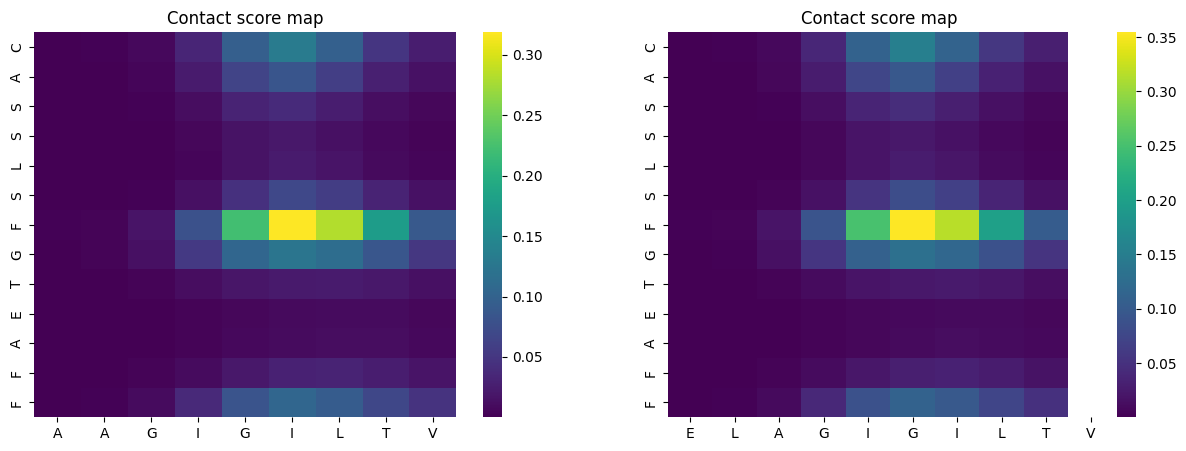

In [11]:
## OK：78，79，82
n_heads = 5

path_saver = 'tansfer__multihead5_fold0_epoch82.pkl'


model_transfer = Transformer().to(device)
model_transfer.load_state_dict(torch.load(path_saver))
import seaborn as sns
model_transfer.eval()
data, pep_inputs, hla_inputs, loader,encoding_mask = data_with_loader(type_ = 'test')
print(list(data['epitope'][0]))

pred_dist, pred_bd = eval_step_corrected(model_transfer,loader,encoding_mask,threshold,use_cuda)
pred_dist_1 = pred_bd[0]*encoding_mask[0]
pred_dist_3 = pred_bd[1]*encoding_mask[1]
rows_to_keep = np.any(encoding_mask[0], axis=1)
cols_to_keep = np.any(encoding_mask[0], axis=0)
pred_dist_1 = pred_dist_1[rows_to_keep][:, cols_to_keep]
pred_dist_3 = pred_dist_3[rows_to_keep][:, cols_to_keep]
temp_pd1 = pd.DataFrame(np.array(pred_dist_1.cpu()))
temp_pd3 = pd.DataFrame(np.array(pred_dist_3.cpu()))
fig = plt.figure(figsize = (10, 6))
# 创建子图
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# 绘制第一个热图
sns.heatmap(temp_pd1, ax=axes[0], cmap='viridis',xticklabels=list(data['epitope'][0]), yticklabels=list(data['cdr3'][0]))
axes[0].set_title('Contact score map')
# 绘制第二个热图
sns.heatmap(temp_pd3, ax=axes[1], cmap='viridis',xticklabels=list(data['epitope'][1]), yticklabels=list(data['cdr3'][1]))
axes[1].set_title('Contact score map')
fig.patch.set_facecolor('white')
# cmap = 'YlGnBu'
# sns.heatmap(temp_pd,cmap = 'coolwarm')

Save fasta file to tmp_faketcr.fasta
 Aligning...
['CASSLSF-------GTEAFF' 'CASSLSF-------GTEAFF' 'CASSLAA-------ATEAFF']
[[17  2 15 15  4 15  6  0  0  0  0  0  0  0  1 16 11  2  6  6]
 [17  2 15 15  4 15  6  0  0  0  0  0  0  0  1 16 11  2  6  6]
 [17  2 15 15  4  2  2  0  0  0  0  0  0  0  2 16 11  2  6  6]]
['A', 'A', 'G', 'I', 'G', 'I', 'L', 'T', 'V']
(3, 5, 32, 32)


sh: 1: ANARCI: not found


<Figure size 1000x600 with 0 Axes>

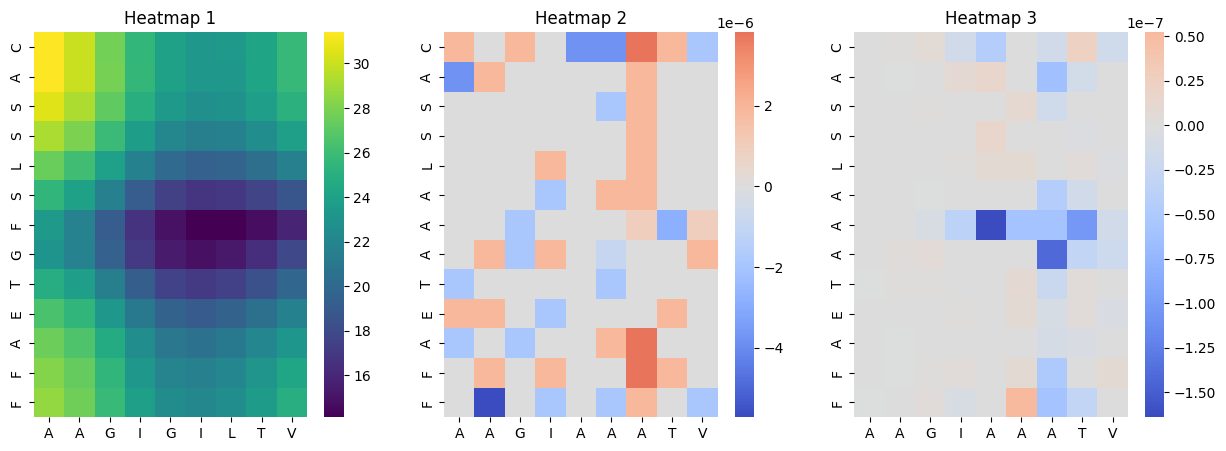

In [12]:
## OK：78，79，82
n_heads = 5
path_saver = 'tansfer__multihead5_fold0_epoch82.pkl'
model_transfer = Transformer().to(device)
model_transfer.load_state_dict(torch.load(path_saver))
import seaborn as sns
model_transfer.eval()
data, pep_inputs, hla_inputs, loader,encoding_mask = data_with_loader(type_ = 'test')
print(list(data['epitope'][0]))


pred_dist, pred_bd = eval_step_corrected(model_transfer,loader,encoding_mask,threshold,use_cuda)
# print(pred_dist[1])
pred_bd_0 = pred_bd[0]*encoding_mask[0]
pred_dist_0 = pred_dist[0]*encoding_mask[0]
pred_bd_2 = pred_bd[2]*encoding_mask[2]
pred_dist_2 = pred_dist[2]*encoding_mask[2]

pred_dist = pred_dist_2-pred_dist_0
pred_bd = pred_bd_2-pred_bd_0
# 检查每一行是否全部为 0，如果不是，则保留该行
rows_to_keep = np.any(encoding_mask[0], axis=1)
# print(rows_to_keep)
# 检查每一列是否全部为 0，如果不是，则保留该列
cols_to_keep = np.any(encoding_mask[0], axis=0)
# print(cols_to_keep)
# 根据保留的行和列，重新构造矩阵 A
pred_dist_0 = pred_dist_0[rows_to_keep][:, cols_to_keep]
pred_dist = pred_dist[rows_to_keep][:, cols_to_keep]
pred_bd = pred_bd[rows_to_keep][:, cols_to_keep]
pred_dist_0 = pd.DataFrame(np.array(pred_dist_0.cpu()))
pred_dist = pd.DataFrame(np.array(pred_dist.cpu()))
pred_bd = pd.DataFrame(np.array(pred_bd.cpu()))
# temp_pd = temp_pd.loc[(temp_pd.sum(axis=1)!=0),(temp_pd.sum(axis=0) !=0)]
# print(encoding_mask[3])
fig = plt.figure(figsize = (10, 6))
# 创建子图
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# 绘制第一个热图
sns.heatmap(pred_dist_0, ax=axes[0], cmap='viridis',xticklabels=list(data['epitope'][0]), yticklabels=list(data['cdr3'][0]))
axes[0].set_title('Heatmap 1')
# 绘制第二个热图
sns.heatmap(pred_dist, ax=axes[1], cmap='coolwarm',center=0,xticklabels=list(data['epitope'][2]), yticklabels=list(data['cdr3'][2]))
axes[1].set_title('Heatmap 2')
# 绘制第三个热图
sns.heatmap(pred_bd, ax=axes[2], cmap='coolwarm',center=0,xticklabels=list(data['epitope'][2]), yticklabels=list(data['cdr3'][2]))
axes[2].set_title('Heatmap 3')
fig.patch.set_facecolor('white')
# cmap = 'YlGnBu'
# sns.heatmap(temp_pd,cmap = 'coolwarm')